In [2]:
!pip3 install scipy
!pip3 install sklearn

In [3]:
#preparation
import pandas as pd


def printDataFrame(df, message):    
    print(message + " \nSize = {}\nShape ={}\n\n"
          .format(df.size, df.shape))

    
print('loading datasets....\n')
dataset_path = './datasets/'

allmusic_df=pd.read_csv(dataset_path + 'acousticbrainz-mediaeval2017-allmusic-train.tsv',delimiter='\t', dtype=str)
printDataFrame(allmusic_df, 'allmusic_df is loaded')


discogs_df=pd.read_csv(dataset_path + 'acousticbrainz-mediaeval2017-discogs-train.tsv',delimiter='\t')
printDataFrame(discogs_df, 'discogs_df is loaded') 


lastfm_df=pd.read_csv(dataset_path + 'acousticbrainz-mediaeval2017-lastfm-train.tsv',delimiter='\t')
printDataFrame(lastfm_df, 'lastfm_df is loaded')  


tagtraum_df=pd.read_csv(dataset_path + 'acousticbrainz-mediaeval2017-tagtraum-train.tsv',delimiter='\t')
printDataFrame(tagtraum_df, 'tagtraum_df is loaded')


#print(allmusic_df.head(5)) #first N rows

loading datasets....

allmusic_df is loaded 
Size = 56834946
Shape =(1353213, 42)




/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


discogs_df is loaded 
Size = 28958208
Shape =(904944, 32)




/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


lastfm_df is loaded 
Size = 6800520
Shape =(566710, 12)


tagtraum_df is loaded 
Size = 5354140
Shape =(486740, 11)




In [4]:
#1.-Take the four datasets and compute the intersection of all of them, based on the recording ID.

def calculate_intersection(dflist, column):
    intersected_temp = pd.merge(dflist[0], dflist[1], how='inner', on=[column])
    for df in dflist[2:]:
        intersected_temp = pd.merge(intersected_temp, df, how='inner', on=[column])
    return intersected_temp


print('computing datasets intersection....\n')
      
intersected_df = calculate_intersection([allmusic_df, discogs_df, lastfm_df, tagtraum_df], 'recordingmbid')        

printDataFrame(intersected_df, 'all 4 intersected')


computing datasets intersection....

all 4 intersected 
Size = 23285304
Shape =(247716, 94)




In [5]:
# 2- Based on this intersection, create a dataset with annotations by all four sources,
# where every subgenre is expressed as a string "sourcename---genrename---subgenrename" 
# to be able to distinguish subgenres coming from different annotation sources.

def add_prefix(val, prefix):
    if (type(val) == str):
        return prefix + val
    
def get_genres(df):
    return df.iloc[:, 2:]

def get_ids(df):
    return df.iloc[:, :2]
     
def add_genre_prefix(df, prefix):
    ids = get_ids(df)
    formatted_genres = get_genres(df).applymap(lambda x: add_prefix(x, prefix))
    return pd.concat([ids, formatted_genres], axis=1)

def remove_nan_columns(df):
    all_na_indexes = df.columns[df.isna().all()].tolist()
    return df.drop(all_na_indexes, axis=1)

print('adding prefixes ...')
lastfm_formatted = add_genre_prefix(lastfm_df,'lastfm---')
discogs_formatted = add_genre_prefix(discogs_df,'discogs---')
allmusic_formatted = add_genre_prefix(allmusic_df,'allmusic---')
tagtraum_formatted = add_genre_prefix(tagtraum_df,'tagtraum---')
print('prefixes added')


intersected_df = calculate_intersection([
    allmusic_formatted, 
    discogs_formatted, 
    lastfm_formatted, 
    tagtraum_formatted],
    'recordingmbid')        

print('intersection claculated \n')
    
intersected_df = remove_nan_columns(intersected_df)
printDataFrame(intersected_df, 'all 4 sources intersected, empty columns removed')

adding prefixes ...
prefixes added
intersection claculated 

all 4 sources intersected, empty columns removed 
Size = 20808144
Shape =(247716, 84)




In [6]:
#3 - If you have too many subgenre labels, remove subgenres that occur for less than 200 recordings 
#(or decide your own threshold).

min_threshold = 200

def is_genre_or_subgenre(string): return "---" in string;

def is_subgenre(string):
    return "---" in string[string.find("---")+3:]

indexs = intersected_df.columns[pd.Series(intersected_df.columns).str.startswith('genre')].tolist()
unique_indexs = list(set(indexs))
genre_columns = intersected_df[unique_indexs] #columns containing genre info
counts = genre_columns.apply(pd.value_counts) 
ranked_counts = counts.sum(axis=1).sort_values(ascending=False)
print(" \n{} labels found \n"
      .format(len(ranked_counts.index[:])))

genre_labels = ranked_counts[ranked_counts>min_threshold].index[:].tolist() #labels over threshold
subgenres_to_keep = [i for i in genre_labels if is_subgenre(i)] #list of subgenres over treshold

print("{} subgenre labels appear more than {} times \n"
      .format(len(subgenres_to_keep), min_threshold))


#remove genres and unwanted subgenres
deleted_subgenres_counter = 0
kept_subgenres_counter = 0

def remove_unwanted_labels(val):
    new_val= val
    if (type(val) == str):
        if is_genre_or_subgenre(val):
            if val not in subgenres_to_keep:
                new_val = None
                global deleted_subgenres_counter
                deleted_subgenres_counter += 1
            else:
                global kept_subgenres_counter
                kept_subgenres_counter +=1
    return new_val

intersected_filtered = intersected_df.applymap(remove_unwanted_labels)

print("{} subgenre/genre values removed,  {} subgenre values kept\n"
      .format(deleted_subgenres_counter, kept_subgenres_counter))

 
1702 labels found 

1060 subgenre labels appear more than 200 times 

1290705 subgenre/genre values removed,  2201023 subgenre values kept



In [7]:
# 4.- Compute a track-subgenre occurrence matrix. Rows represent tracks, columns represent subgenres.
# Each cell represents if a particular track is annotated by a particular subgenrename (1 or 0).
# This matrix allows to compute similarity between subgenres using a cosine distance between columns, 
# and we can use this similarity to cluster similar subgenres together.
from collections import OrderedDict
from IPython.display import display, clear_output


def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros


def create_subgenre_to_trackIndexes_map(df, subgenres, tracks):
    subgenre_to_trackIndexes = {}
    
    for subgenre in subgenres:
        subgenre_to_trackIndexes[subgenre] = zerolistmaker(len(tracks)) #initialize subgenre_to_trackIndexes map

    genre_columns = df.columns[pd.Series(df.columns).str.startswith('genre')].tolist()    
    genre_columns_df = df[genre_columns]
    
    for index in range(len(tracks)):
        clear_output(wait=True)
        display('Iteration '+str(index)+' Progress: '+str(round((index/len(tracks))*100,2)) + '%') #print progress
        
        subgenres = genre_columns_df.iloc[index].values #get subgenres for a track as list
        for subgenre in subgenres:
            if subgenre is not None:
                subgenre_to_trackIndexes[subgenre][index] = 1
    return subgenre_to_trackIndexes



subgenres_to_keep #subgenre list
track_ids = intersected_filtered.iloc[:,0].tolist()
dest = OrderedDict([('recordingmbid', track_ids) ])

print('computing subgenre_to_trackIndexes map, it will take a while (>15 min)... \n')
subgenre_to_trackIndexes = create_subgenre_to_trackIndexes_map(intersected_filtered, subgenres_to_keep, track_ids)
dest.update(subgenre_to_trackIndexes)

track_subgenre_ocurrence_matrix = pd.DataFrame.from_dict(dest)
printDataFrame(track_subgenre_ocurrence_matrix, 'track_subgenre_ocurrence_matrix computed')

track_subgenre_ocurrence_matrix.head(2)
#df.set_index('recordingmbid')

'Iteration 247649 Progress: 99.97%'

'Iteration 247715 Progress: 100.0%'

track_subgenre_ocurrence_matrix computed 
Size = 262826676
Shape =(247716, 1061)




,recordingmbid,allmusic---pop/rock---alternative/indie rock,tagtraum---rock/pop---alternative,tagtraum---rock/pop---pop,allmusic---pop/rock---alternative pop/rock,allmusic---pop/rock---pop/rock,allmusic---pop/rock---heavy metal,allmusic---pop/rock---hard rock,allmusic---pop/rock---contemporary pop/rock,tagtraum---rock/pop---metal,...,lastfm---pop---westcoastswing,allmusic---jazz---chamber jazz,discogs---latin---afro-cuban,allmusic---pop/rock---french rock,lastfm---electronic---rave,lastfm---metal---norwegian,allmusic---comedy/spoken---standup comedy,lastfm---brazilian---samba,allmusic---comedy/spoken---spoken word,allmusic---international---samba
0,1a00a335-fead-46ec-8d4f-06e8341291ea,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6a458aa4-698a-410b-b7ad-025fd8fcb071,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
# 5 -Compute the distance matrix (cosine distance) for subgenres across all sources.
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity

#cosine_similarity will directly compute cosine distance between rows for a dataframe
# https://stackoverflow.com/questions/45387476/cosine-similarity-between-each-row-in-a-dataframe-in-python

# transpose it so we can perform similarity between rows
ocurrence_matrix = track_subgenre_ocurrence_matrix.drop(columns="recordingmbid").T 
dist = cosine_similarity(ocurrence_matrix)

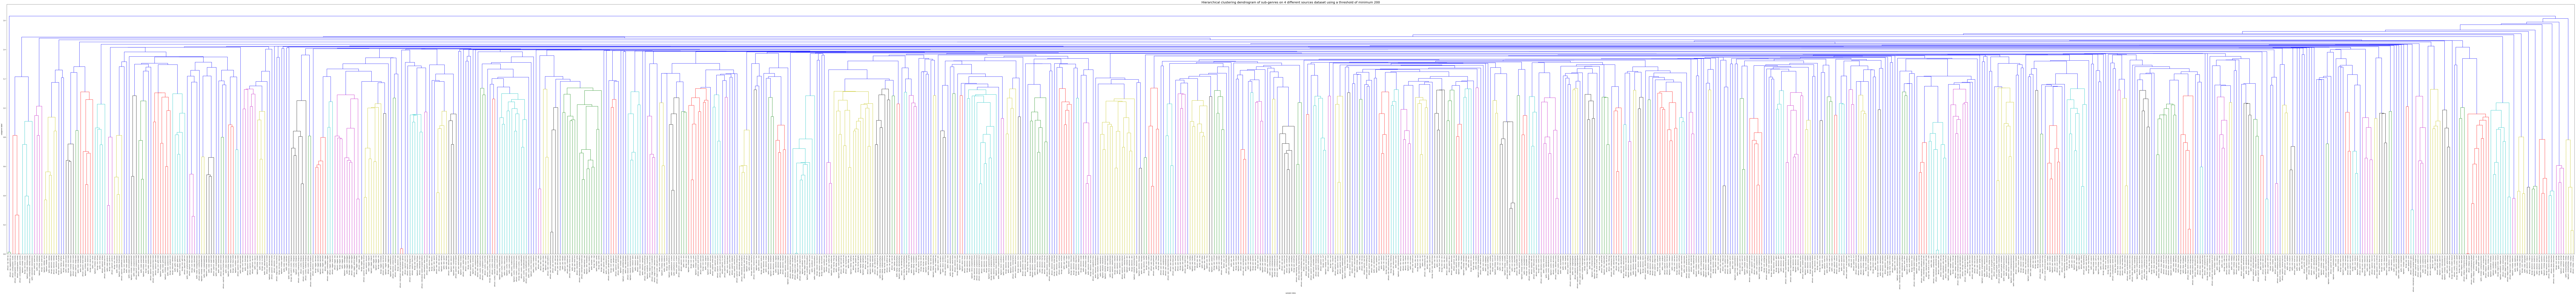

In [137]:
# 6- Use a hierarchical clustering algorithm to cluster subgenres. 
#Visualize dendrograms (generate a huge high-resolution dendrogram image listing all analyzed subgenres). 
#This will be a very huge image to fit in the report, so it may be better to arrange it in a way that the subgenres are stacked vertically (or include it as an attachment pdf/png). 
#Consider showing just a few zoomed-in images of interesting genres.

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html

%matplotlib inline
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib 
from matplotlib import pyplot as plt

#Perform hierarchical/agglomerative clustering.
Z = linkage(dist, optimal_ordering=True)

plt.figure(figsize=(300, 30))

plt.title('Hierarchical clustering dendrogram of sub-genres on 4 different sources dataset using a threshold of minimum '
          +str(min_threshold), fontsize = 20)
plt.xlabel('sample index')
plt.ylabel('subgenre label')

#dendrogram(Z, labels=subgenres_to_keep)
dendrogram(
    Z,
    labels=subgenres_to_keep,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)



plt.savefig("dendogram.png", facecolor=('white'), edgecolor='none')
plt.show()

In [121]:
# SOME TESTS

#-----------------------------------------------
#create_subgenre_to_trackIndexes_map
test_tracks = ['track1', 'track2', 'track3']
test_genres = ['rock', 'dance', 'blues', 'experimental']
test_intersect = OrderedDict([ ('recordingmbid', test_tracks),
          ('genre1', [None, 'rock', None]),
          ('genre2', [None, 'blues', 'dance'] ),
          ('genre3', [None, 'dance', None] ),
          ('other_stuff', ['id', 'id', 'id'] ),                   
          ('genre4', ['rock', None, None] )])
df_test = pd.DataFrame.from_dict(test_intersect)

expected_result = {'rock': [1, 1, 0], 'dance': [0, 1, 1], 'blues': [0, 1, 0], 'experimental': [0, 0, 0]}
actual_result = create_subgenre_to_trackIndexes_map(df_test, test_genres, test_tracks)
print(expected_result == actual_result)


#-----------------------------------------------
print(lastfm_df.equals(pd.concat([get_ids(lastfm_df), get_genres(lastfm_df)], axis=1)))


#-----------------------------------------------
intersected_test = pd.merge(allmusic_df, discogs_df, how='inner', on=['recordingmbid'])
intersected_test = pd.merge(intersected_test, lastfm_df, how='inner', on=['recordingmbid'])
intersected_test = pd.merge(intersected_test, tagtraum_df, how='inner', on=['recordingmbid'])
print(intersected_test.equals(calculate_intersection([allmusic_df, discogs_df, lastfm_df, tagtraum_df], 'recordingmbid'))) 


#-----------------------------------------------
print(not is_subgenre('discogs---jazz'))
print(is_subgenre('discogs---classical---impressionist'))



#-----------------------------------------------
#remove unwanted labels fuction to be applied to each dataframe cell
print(remove_unwanted_labels("allmusic---rap---reggaeton") == None)
print(remove_unwanted_labels("tagtraum---rock/pop---alternative") == "tagtraum---rock/pop---alternative")
print(remove_unwanted_labels("should be equal") == "should be equal")
print(remove_unwanted_labels(1) == 1)








'Iteration 2 Progress: 66.67%'

True
True
True
True
True
True
True
True
True


In [119]:
print(subgenres_to_keep[:4])
ocurrence_matrix.head(4)


['allmusic---pop/rock---alternative/indie rock', 'tagtraum---rock/pop---alternative', 'tagtraum---rock/pop---pop', 'allmusic---pop/rock---alternative pop/rock']


,0,1,2,3,4,5,6,7,8,9,...,247706,247707,247708,247709,247710,247711,247712,247713,247714,247715
allmusic---pop/rock---alternative/indie rock,0,1,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,1,1,1,0
tagtraum---rock/pop---alternative,0,0,0,0,0,1,0,1,1,1,...,1,0,0,0,0,0,1,1,0,0
tagtraum---rock/pop---pop,0,0,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
allmusic---pop/rock---alternative pop/rock,0,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
